In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import sklearn
import shap
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, recall_score, f1_score

/Users/xuqidi/myenv/lib/python3.7/site-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/Users/xuqidi/myenv/lib/python3.7/site-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")

## Data

In [3]:
valid_days = pd.read_csv('included_days.txt', sep='\t') 

In [4]:
activities = pd.read_csv('activities_final.txt', sep='\t') 
activities = activities.drop(['activity_Run', 'activity_Walk', 'gender', 'race', 'caloriesBMR', 'activeScore'], axis = 1)

In [5]:
#remove partial days in activities 
activity = pd.merge(activities, valid_days, left_on=['User', 'Date'], right_on=['User', 'Day'])
activity.drop('Day', axis=1, inplace=True)

In [6]:
sleep = pd.read_csv('sleep_final.txt', sep='\t')

In [7]:
#divide into main sleep and naps
def classify_sleep(row):
    main_sleep_conditions = all(pd.isna(row[key]) for key in ['asleep_count', 'asleep_minutes', 
                                                             'awake_count', 'awake_minutes',
                                                             'restless_minutes', 'restless_count'])
    nap_conditions = all(pd.isna(row[key]) for key in ['deep_count', 'deep_minutes', 'deep_thirtyDayAvgMinutes', 
                                                      'light_count', 'light_minutes', 'light_thirtyDayAvgMinutes',
                                                      'rem_count', 'rem_minutes', 'rem_thirtyDayAvgMinutes',
                                                      'wake_count', 'wake_minutes', 'wake_thirtyDayAvgMinutes'])
    if nap_conditions:
        return "Nap"
    elif main_sleep_conditions:
        return "Main Sleep"
    else:
        return "Inconclusive" 

sleep['classification'] = sleep.apply(classify_sleep, axis=1)

In [8]:
mainsleep = sleep[sleep['classification']=='Main Sleep']
mainsleep = mainsleep.drop(['startTime', 'endTime', 
                'duration', 'isMainSleep', 'classification',
                'gender', 'race'], axis=1) 
mainsleep = mainsleep.dropna(axis = 1)

## Activities + Heart rate + Main sleep

In [9]:
common_features = ['label', 'User', 'age', 'Date']
df = pd.merge(activity, mainsleep, on=common_features, how='inner')

In [10]:
unique_df = df[['User', 'label']].drop_duplicates()
unique_df.set_index('User', inplace=True)

In [11]:
df = df.drop(['label', 'Date'], axis = 1)

## Featuretools

In [12]:
es = ft.EntitySet(id = 'data_activities_heart_mainsleep')
es.add_dataframe(dataframe_name = 'AHM', dataframe = df, make_index = True, index = 'ahm_index')

Entityset: data_activities_heart_mainsleep
  DataFrames:
    AHM [Rows: 524, Columns: 58]
  Relationships:
    No relationships

In [13]:
es.normalize_dataframe(base_dataframe_name='AHM', new_dataframe_name='person', index = 'User', 
            additional_columns = ['age'])

Entityset: data_activities_heart_mainsleep
  DataFrames:
    AHM [Rows: 524, Columns: 57]
    person [Rows: 20, Columns: 2]
  Relationships:
    AHM.User -> person.User

In [14]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
target_dataframe_name = 'person', 
max_depth = 2, 
verbose = 1 
)

Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


## Feature Selection

In [15]:
y = unique_df['label']
X = feature_matrix

In [16]:
alpha = 0.02
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

ix_training, ix_test = [], []

for fold in kf.split(X):
    ix_training.append(fold[0]), ix_test.append(fold[1])

models = []
auc_scores = []
feature_occurrences = {} 

for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
    X_train, y_train = X.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    #model
    model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=10, l2_leaf_reg=4, random_seed=8, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features = [], verbose = 0)
    
    #SHAP in training
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    shap_importance = np.mean(np.abs(np.array(shap_values)), axis = 0)
    important_features = np.array(X_train.columns)[shap_importance > alpha]

    #count
    for feature in important_features:
        if feature in feature_occurrences:
            feature_occurrences[feature] += 1
        else:
            feature_occurrences[feature] = 1

    #test with selected features
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]

    model.fit(X_train_selected, y_train, cat_features = [], verbose = 0)
    
    yhat_probs = model.predict_proba(X_test_selected)[:, 1]
    
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        auc_scores.append(float('nan'))
        
    models.append(model)


Skipping AUC calculation for this fold due to single class in y_true.


In [17]:
print('The mean AUC of the 5 folds is ', np.nanmean(auc_scores))
print('The std AUC of the 5 folds is ', np.nanstd(auc_scores))

The mean AUC of the 5 folds is  1.0
The std AUC of the 5 folds is  0.0


In [18]:
final_selected_features = [feature for feature, count in feature_occurrences.items() if count >= 2]

In [19]:
X_filtered = X[final_selected_features]

In [20]:
print(X_filtered.shape)
print(y.shape)

(20, 15)
(20,)


In [21]:
X_filtered.columns

Index(['MAX(AHM.lightlyActiveMinutes)', 'MEAN(AHM.deep_thirtyDayAvgMinutes)',
       'SKEW(AHM.heartRateZone_Fat_Burn_caloriesOut)',
       'STD(AHM.heartRateZone_Peak_max)',
       'SUM(AHM.heartRateZone_Fat_Burn_caloriesOut)',
       'SUM(AHM.heartRateZone_Fat_Burn_minutes)',
       'SUM(AHM.lightlyActiveMinutes)', 'MEAN(AHM.restingHeartRate)',
       'MIN(AHM.restingHeartRate)', 'STD(AHM.heartRateZone_Cardio_min)',
       'SUM(AHM.activity_lightlyActive)', 'SUM(AHM.restingHeartRate)',
       'MEAN(AHM.heartRateZone_Fat_Burn_minutes)',
       'SKEW(AHM.heartRateZone_Cardio_min)',
       'SKEW(AHM.heartRateZone_Peak_max)'],
      dtype='object')

In [22]:
new_labels = ['MAX(lightly active minutes)', 'MEAN(deep sleep minutes)','SKEW(heart rate zone fat burn calories out)',
'STD(heart rate zone peak max)','SUM(heart rate zone fat burn calories out)','SUM(heart rate zone fat burn minutes)', 
'SUM(lightly active minutes)','MEAN(resting heart rate)', 'MIN(resting heart rate)',
'STD(heart rate zone cardio min)', 'SUM(lightly active distance)','SUM(resting heart rate)', 
'MEAN(heart rate zone fat burn minutes)','SKEW(heart rate zone cardio min)', 'SKEW(heart rate zone peak max)']
X_filtered.columns = new_labels

In [23]:
from sklearn.preprocessing import StandardScaler
scaler_z = StandardScaler()
original_index = X_filtered.index
scaled_data = scaler_z.fit_transform(X_filtered)
X_filtered = pd.DataFrame(scaled_data, index=original_index, columns=X_filtered.columns)

## Evaluation

### CatBoost Repeated K fold

In [24]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []
all_shap_values = []
all_X_tests = []

tprs = []
mean_fpr = np.linspace(0,1,100)

fold_results = []

precision_scores = []
recall_scores = []
f1_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features=[], verbose=0)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    yhat_labels = model.predict(X_test)
    
    #store
    for User, true_label, pred_label, pred_prob in zip(X_filtered.iloc[test_outer_ix].index.values, y_test, yhat_labels, yhat_probs):
        fold_results.append([User, true_label, pred_prob, pred_label])
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 

    #ROC
    if len(np.unique(y_test)) > 1: 
        fpr, tpr, t = roc_curve(y_test, yhat_probs)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
    else:
        continue
    
    #other metrics
    precision = precision_score(y_test, yhat_labels)
    recall = recall_score(y_test, yhat_labels)
    f1 = f1_score(y_test, yhat_labels)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
        
    #compute SHAP values for the current test set
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    all_X_tests.append(X_test)

    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [25]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Kfold after feature selection:", mean_auc)

Mean AUC using Kfold after feature selection: 1.0


In [26]:
print('Mean precision score is:', np.mean(precision_scores))
print('Mean recall score is:', np.mean(recall_scores))
print('Mean F1 score is:', np.mean(f1_scores))

Mean precision score is: 1.0
Mean recall score is: 0.9365079365079364
Mean F1 score is: 0.9587301587301589


In [27]:
results_df = pd.DataFrame(fold_results, columns=['User', 'True Label', 'Predicted Probability', 'Predicted Label'])
results_df.to_csv('detail_info_AHM.csv', index=False)

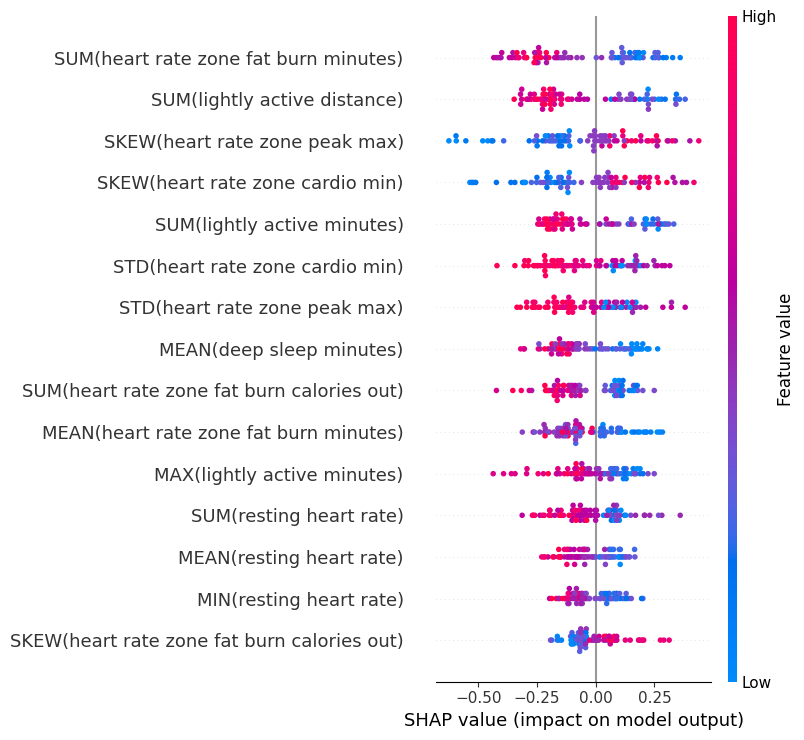

In [28]:
aggregated_shap_values = np.vstack(all_shap_values)
aggregated_X_test = pd.concat(all_X_tests)
shap.summary_plot(aggregated_shap_values, aggregated_X_test, show = False)
plt.savefig('SHAP Final.pdf', dpi=1000, bbox_inches='tight')
plt.show()

#### LOOCV

In [29]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []
all_results = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]
    
    userids_test = X_filtered.iloc[test_ix].index.values

    model = CatBoostClassifier(iterations=100, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features = [], verbose = 0)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #predict labels
    yhat_labels = model.predict(X_test)
    
    #store results
    fold_results = pd.DataFrame({
        'User': userids_test,
        'true_label': y_test.values,
        'predicted_proba': yhat_probs,
        'predicted_label': yhat_labels
    })
    all_results.append(fold_results)
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)
results_df = pd.concat(all_results, ignore_index=True)

In [30]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 1.0000


In [31]:
all_yhat_probs

[0.5487166090499948,
 0.5263404400150474,
 0.5452307287515076,
 0.4879224302988943,
 0.5147349003764359,
 0.4383922397333248,
 0.49172611973726493,
 0.42821357916413666,
 0.5488300729836689,
 0.5344119044772107,
 0.4837441460616968,
 0.47801815747994236,
 0.5028041353861398,
 0.5179360377347348,
 0.511299549214439,
 0.43986217790022236,
 0.5517226467683007,
 0.48007727076525125,
 0.5234965248647643,
 0.4369329361278588]

In [32]:
results_df.to_csv('detail_info_AHM_Loocv.csv', index=False)

### RF

In [33]:
from sklearn.ensemble import RandomForestClassifier

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=7)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [34]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9880952380952381


In [35]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=7)
    model.fit(X_train, y_train)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [36]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9375


### XGBoost

In [37]:
import xgboost as xgb
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=8, 
                              random_state=7, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train, verbose=10)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [38]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9365079365079364


In [39]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=8, 
                              random_state=7, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train, verbose=10)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)

In [40]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9167


### SVM

In [41]:
from sklearn.svm import SVC

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = SVC(probability=True, kernel='linear', random_state=7)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [42]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9484126984126983


In [43]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = SVC(probability=True, kernel='sigmoid', random_state=7)
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [44]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9271


### LR

In [45]:
from sklearn.linear_model import LogisticRegression

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = LogisticRegression(random_state=7, max_iter=200)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [46]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9365079365079364


In [47]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = LogisticRegression(random_state=7, max_iter=200)
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [48]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9271


### GNB

In [49]:
from sklearn.naive_bayes import GaussianNB

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [50]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9722222222222221


In [51]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = GaussianNB()
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [52]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9167


## Activities + Heart Rate + Naps

In [53]:
naps = sleep[sleep['classification']=='Nap']
naps = naps.drop(['startTime', 'endTime', 'duration', 'isMainSleep', 'classification', 'gender', 'race'], axis=1) 
naps = naps.dropna(axis = 1)

In [54]:
common_features = ['label', 'User', 'age', 'Date']
df = pd.merge(activity, naps, on=common_features, how='inner')

In [55]:
unique_df = df[['User', 'label']].drop_duplicates()
unique_df.set_index('User', inplace=True)

In [56]:
df = df.drop(['label', 'Date'], axis = 1)

## Featuretools

In [57]:
es = ft.EntitySet(id = 'data_activities_nap')
es.add_dataframe(dataframe_name = 'AHN', dataframe = df, make_index = True, index = 'ahn_index')

Entityset: data_activities_nap
  DataFrames:
    AHN [Rows: 171, Columns: 52]
  Relationships:
    No relationships

In [58]:
es.normalize_dataframe(base_dataframe_name='AHN', new_dataframe_name='person', index = 'User', 
            additional_columns = ['age'])

Entityset: data_activities_nap
  DataFrames:
    AHN [Rows: 171, Columns: 51]
    person [Rows: 15, Columns: 2]
  Relationships:
    AHN.User -> person.User

In [59]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
target_dataframe_name = 'person', 
max_depth = 2, 
verbose = 1 
)

Built 296 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


## Feature Selection

In [60]:
y = unique_df['label']
X = feature_matrix

In [61]:
alpha = 0.02
kf = KFold(n_splits=5, shuffle=True, random_state=40) 

ix_training, ix_test = [], []

for fold in kf.split(X):
    ix_training.append(fold[0]), ix_test.append(fold[1])

models = []
auc_scores = []
feature_occurrences = {} 

for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
    X_train, y_train = X.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    #model
    model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=10, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features = [], verbose = 0)

    #SHAP in training
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    shap_importance = np.mean(np.abs(np.array(shap_values)), axis = 0)
    important_features = np.array(X_train.columns)[shap_importance > alpha]

    #count
    for feature in important_features:
        if feature in feature_occurrences:
            feature_occurrences[feature] += 1
        else:
            feature_occurrences[feature] = 1

    #test with selected features
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]

    model.fit(X_train_selected, y_train, cat_features = [], verbose = 0)
    
    yhat_probs = model.predict_proba(X_test_selected)[:, 1]
    
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        auc_scores.append(float('nan'))
        
    models.append(model)


Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [62]:
print('The mean AUC of the 5 folds is ', np.nanmean(auc_scores))
print('The std AUC of the 5 folds is ', np.nanstd(auc_scores))

The mean AUC of the 5 folds is  0.8333333333333334
The std AUC of the 5 folds is  0.23570226039551584


In [63]:
final_selected_features = [feature for feature, count in feature_occurrences.items() if count >= 2]

In [64]:
X_filtered = X[final_selected_features]
print(X_filtered.shape)
print(y.shape)

(15, 13)
(15,)


In [65]:
X_filtered.columns

Index(['MAX(AHN.activityCalories)', 'SKEW(AHN.activity_lightlyActive)',
       'SKEW(AHN.activity_tracker)', 'SKEW(AHN.heartRateZone_Cardio_minutes)',
       'SKEW(AHN.lightlyActiveMinutes)', 'SKEW(AHN.marginalCalories)',
       'SKEW(AHN.steps)', 'SKEW(AHN.timeInBed)', 'SKEW(AHN.total)',
       'SKEW(AHN.veryActiveMinutes)', 'STD(AHN.activity_lightlyActive)',
       'SKEW(AHN.activityCalories)', 'SKEW(AHN.fairlyActiveMinutes)'],
      dtype='object')

In [66]:
from sklearn.preprocessing import StandardScaler
scaler_z = StandardScaler()
original_index = X_filtered.index
scaled_data = scaler_z.fit_transform(X_filtered)
X_filtered = pd.DataFrame(scaled_data, index=original_index, columns=X_filtered.columns)

In [67]:
from sklearn.impute import KNNImputer
original_index = X_filtered.index
imputer = KNNImputer(n_neighbors=4)
X_imputed = imputer.fit_transform(X_filtered)
X_filtered = pd.DataFrame(X_imputed, index=original_index, columns=X_filtered.columns)

## Evaluation

### CatBoost Repeated K fold

In [68]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []
all_shap_values = []
all_X_tests = []

tprs = []
mean_fpr = np.linspace(0,1,100)

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features=[], verbose=0)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 

    #ROC
    if len(np.unique(y_test)) > 1: 
        fpr, tpr, t = roc_curve(y_test, yhat_probs)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
    else:
        continue
    
    #compute SHAP values for the current test set
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    all_X_tests.append(X_test)
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [69]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Kfold after feature selection:", mean_auc)

Mean AUC using Kfold after feature selection: 0.9444444444444444


#### LOOCV

In [70]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []
all_results = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]
    
    userids_test = X_filtered.iloc[test_ix].index.values

    model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
    model.fit(X_train, y_train, cat_features = [], verbose = 0)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)

In [71]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.8864


### XGBoost

In [72]:
import xgboost as xgb
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=8, 
                              random_state=7, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train, verbose=0)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [73]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9027777777777778


In [74]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=8, 
                              random_state=7, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train, verbose=0)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)

In [75]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9091


### RF

In [76]:
from sklearn.ensemble import RandomForestClassifier

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=7)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [77]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9166666666666666


In [78]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=7)
    model.fit(X_train, y_train)

    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [79]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.8636


### SVM

In [80]:
from sklearn.svm import SVC

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = SVC(probability=True, kernel='linear', random_state=7)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [81]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.8611111111111112


In [82]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = SVC(probability=True, kernel='linear', random_state=7)
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)

In [83]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.8409


### LR

In [84]:
from sklearn.linear_model import LogisticRegression

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = LogisticRegression(random_state=8, max_iter=200)
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [85]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.9615384615384616


In [86]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = LogisticRegression(random_state=8, max_iter=200)
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)

In [87]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.9545


### GNB

In [88]:
from sklearn.naive_bayes import GaussianNB

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = []
r_auc_scores = []

for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_filtered)): 
    X_train, y_train = X_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
    X_test, y_test = X_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    
    #test
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    #auc
    try:
        auc = roc_auc_score(y_test, yhat_probs)
        r_auc_scores.append(auc)
    except ValueError:
        print("Skipping AUC calculation for this fold due to single class in y_true.")
        r_auc_scores.append(float('nan')) 
    
    models.append(model)

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [89]:
mean_auc = np.nanmean(r_auc_scores)
print("Mean AUC using Repeated Kfold after feature selection:", mean_auc)

Mean AUC using Repeated Kfold after feature selection: 0.7777777777777778


In [90]:
cv = LeaveOneOut()

models = []
all_y_test = []
all_yhat_probs = []

for train_ix, test_ix in cv.split(X_filtered):
    X_train, y_train = X_filtered.iloc[train_ix], y.iloc[train_ix]
    X_test, y_test = X_filtered.iloc[test_ix], y.iloc[test_ix]

    model = GaussianNB()
    model.fit(X_train, y_train)
    
    yhat_probs = model.predict_proba(X_test)[:, 1]
    
    all_y_test.extend(y_test)
    all_yhat_probs.extend(yhat_probs)
        
    models.append(model)


In [91]:
auc = roc_auc_score(all_y_test, all_yhat_probs)
print(f"AUC Score across all LOO iterations: {auc:.4f}")

AUC Score across all LOO iterations: 0.6705
